In [102]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import feature_extraction, preprocessing, linear_model, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from pandas_profiling import ProfileReport
import scikitplot as skplt
import string
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification, BertConfig, AdamW, get_linear_schedule_with_warmup
import torch
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bert
import sys
import os
sys.path.append('../utility')
import utils

# seaborn settings
sns.set_theme(style="whitegrid")
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# download pickles
train_df = pd.read_pickle("../data/pickles/clean_train_data.pkl")
test_df = pd.read_pickle("../data/pickles/clean_test_data.pkl")

In [8]:
# create final dfs without text col
train_labels = final_train_df['target']
final_train_df = train_df.drop(columns=['text', 'id', 'target'])
final_test_df = test_df.drop(columns=['text', 'id'])

**Non-text data: final expansion of metafeatures using one-hot encoding to make them less revelant in model.**

In order to incorporate our metafeatures into our modelling, we need to introduce them to a neural network after out BERT modelling. This is because they won't be interpreted correctly otherwise. We can prepare them here by simply normalising using `MinMaxScaler()`.

In [10]:
# normalise columns
scaler = MinMaxScaler()
final_train_df = scaler.fit_transform(final_train_df)
final_test_df = scaler.fit_transform(final_test_df)

**Get labels and train-test split.**

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(final_train_df, train_labels, test_size=0.3, random_state=42)

In [87]:
# create CNN
model = Sequential()
model.add(Dense(90, input_dim=9, activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dense(100))
model.add(Dense(20, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# compile and summarise
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# first fit is history1
history = model.fit(X_test, y_test, epochs=1000, batch_size=64, validation_data=(X_test, y_test), verbose=0)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 90)                900       
_________________________________________________________________
dense_92 (Dense)             (None, 120)               10920     
_________________________________________________________________
dense_93 (Dense)             (None, 100)               12100     
_________________________________________________________________
dense_94 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 21        
Total params: 25,961
Trainable params: 25,961
Non-trainable params: 0
_________________________________________________________________


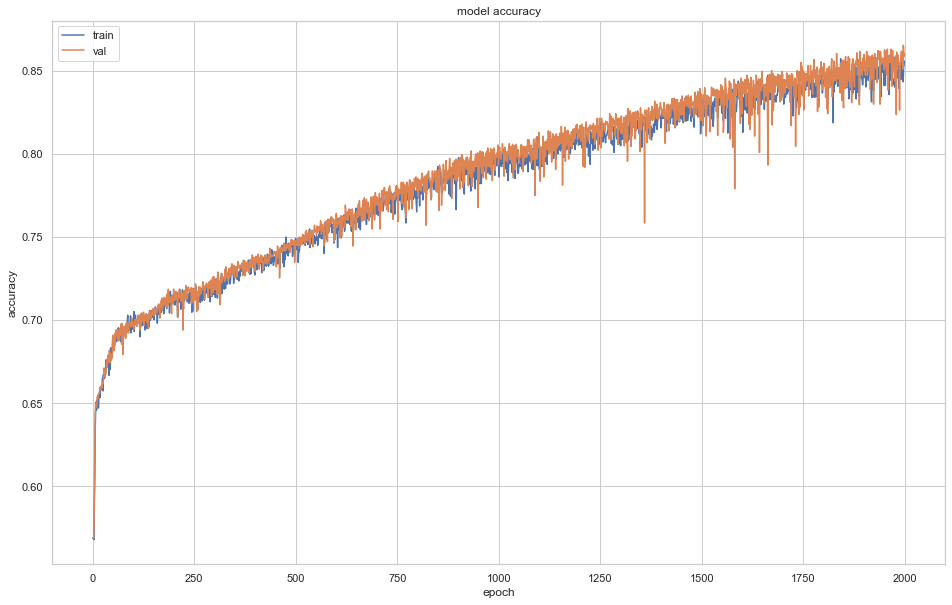

In [88]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

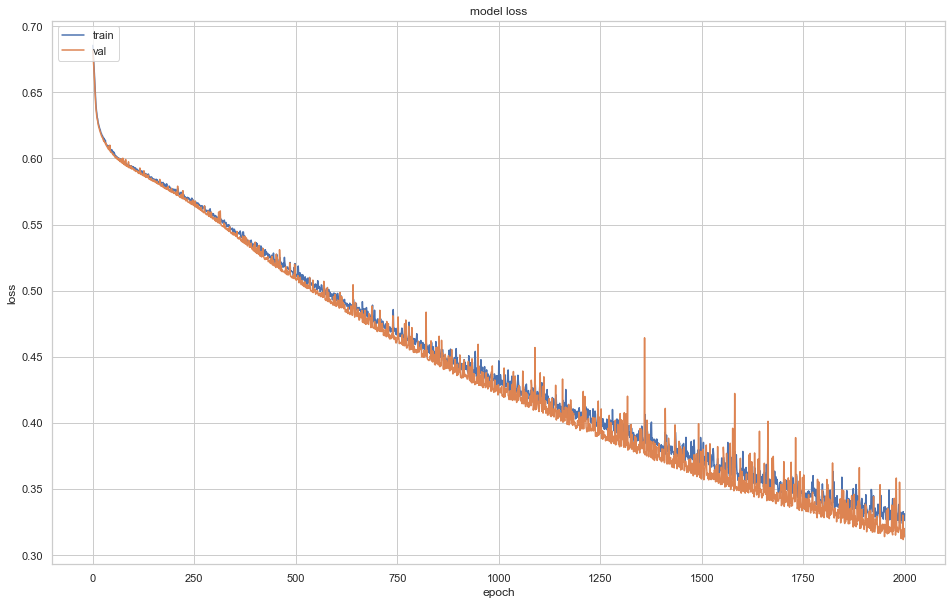

In [89]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# predictions
test_pred = model.predict(X_test)
print(test_pred)

[[1.4951229e-03]
 [6.5689826e-01]
 [8.7453091e-01]
 ...
 [2.9507664e-01]
 [8.4444880e-04]
 [9.7504020e-01]]


In [91]:
# this checks if the probability of disaster is above 0.5. If so, we label 1.
test_pred_bool = test_pred.copy().astype(int)
for index in range(len(test_pred)): 
    if test_pred[index]>0.5:
        test_pred_bool[index]=1
    else:
        test_pred_bool[index]=0

In [92]:
final_predictions = test_pred_bool.flatten()

In [93]:
# model test function
def eval_model(predictions):
    print(accuracy_score(y_test, predictions))
    # Compute fpr, tpr, thresholds and roc auc
    fpr, tpr, thresholds = roc_curve(np.array(y_test), np.array(predictions))
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_test, np.array(predictions), target_names=["not disaster", "disaster"]))

0.8604026845637583


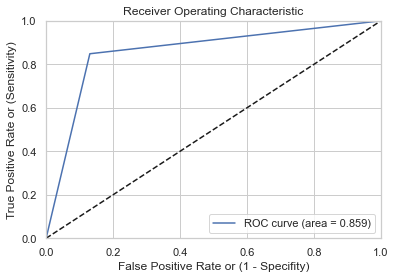

              precision    recall  f1-score   support

not disaster       0.88      0.87      0.88      1271
    disaster       0.83      0.85      0.84       964

    accuracy                           0.86      2235
   macro avg       0.86      0.86      0.86      2235
weighted avg       0.86      0.86      0.86      2235



In [94]:
eval_model(final_predictions)

In [95]:
# actual test predictions
real_pred = model.predict(final_test_df)
print(real_pred)

[[0.5641937 ]
 [0.27554685]
 [0.14862344]
 ...
 [0.5884286 ]
 [0.3882533 ]
 [0.9980986 ]]


In [104]:
# this checks if the probability of disaster is above 0.5. If so, we label 1.
real_pred_bool = real_pred.copy().astype(int)
for index in range(len(real_pred)): 
    if real_pred[index]>0.5:
        real_pred_bool[index]=1
    else:
        real_pred_bool[index]=0

In [105]:
real_predictions = real_pred_bool.flatten()

### Preparing Kaggle Submission

All we need to do now is turn our output probabilities of our machine learning model into boolean values and submit the predictions!

In [109]:
submission = pd.read_csv("../data/submissions/submission.csv")
submission["target"] = real_predictions
submission.to_csv('../data/submissions/submission5.csv', index=False)

To submit, we use the Kaggle API and type the following:

`kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"`